# TinyML - Post-Training Pruning (PTP)


#### Federal University of Rio Grande do Norte

#### Name: Thommas Kevin Sales Flores


## 0. Install the libraries listed in the requirements.txt file

In [1]:
#!pip install -r requirements.txt

## 1. Importing libraries

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
import tensorflow_model_optimization as tfmot
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model
# Apply ggplot style
plt.style.use('ggplot')

## 2. Load Dataset

MNIST, short for Modified National Institute of Standards and Technology database, is a widely used dataset in the field of machine learning and computer vision. It consists of a collection of handwritten digits ranging from 0 to 9, each digit being represented as a grayscale image of size 28x28 pixels. The dataset contains a total of 70,000 images, with 60,000 images used for training and 10,000 images used for testing.

link: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [3]:
def get_data():
    np.random.seed(1337)
    x_values, y_values = load_digits(return_X_y=True)
    x_values /= x_values.max()
    # reshape to (8 x 8 x 1)
    x_values = x_values.reshape((len(x_values), 8, 8, 1))
    # split into train, validation, test
    TRAIN_SPLIT = int(0.6 * len(x_values))
    TEST_SPLIT = int(0.2 * len(x_values) + TRAIN_SPLIT)
    x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
    y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

    return x_train, x_test, x_validate, y_train, y_test, y_validate

## 3. Splitting the data

In [4]:
X_train, X_test, X_validate, y_train, y_test, y_validate = get_data()

## 4. Exploratory Data Analysis

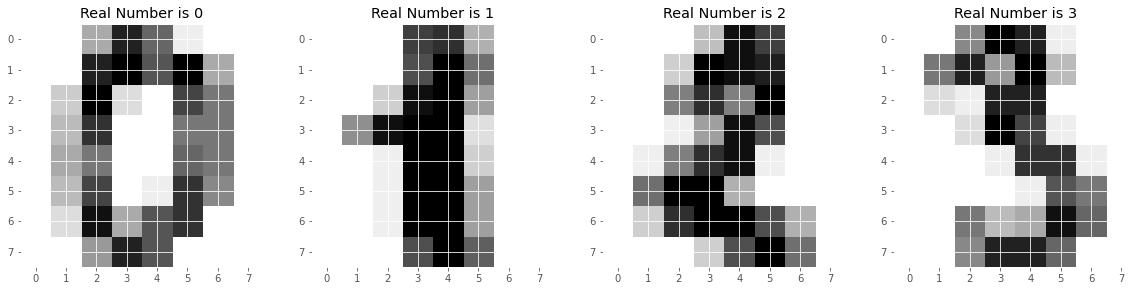

In [5]:
X_train__ = X_train.reshape(X_train.shape[0], 8, 8)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i]
    ax.set(title = f"Real Number is {digit}")

## 5. Define the model

In [6]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(8, 8, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])
    return model

In [7]:
model = build_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 8)           80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 72)                0         
                                                                 
 dense (Dense)               (None, 100)               7300      
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 8390 (32.77 KB)
Trainable params: 8390 (32.77 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

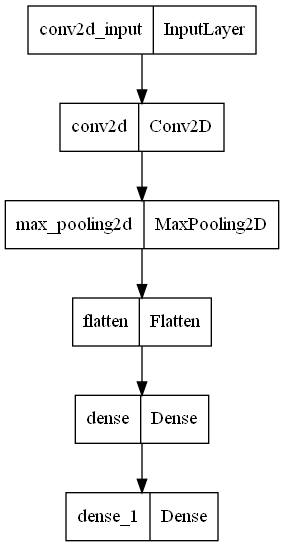

In [9]:
plot_model(model, to_file='./figures/model.png')

## 6. Compile the model

In [10]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## 7. Training model

In [11]:
# Treinar o modelo original
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


34/34 [==============================] - 2s 18ms/step - loss: 2.2122 - accuracy: 0.2996 - val_loss: 2.0539 - val_accuracy: 0.5627
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 1.9009 - accuracy: 0.6809 - val_loss: 1.6621 - val_accuracy: 0.7967
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 1.4363 - accuracy: 0.8237 - val_loss: 1.1390 - val_accuracy: 0.8747
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 0.9458 - accuracy: 0.8683 - val_loss: 0.7319 - val_accuracy: 0.9053
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.6210 - accuracy: 0.9128 - val_loss: 0.4988 - val_accuracy: 0.9081
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.4448 - accuracy: 0.9249 - val_loss: 0.3817 - val_accuracy: 0.9276
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.3368 - accuracy: 0.9406 - val_loss: 0.3112 - val_accuracy: 0.9192
Epoch 8/10

In [12]:
model.save('.\models\original_model.keras')

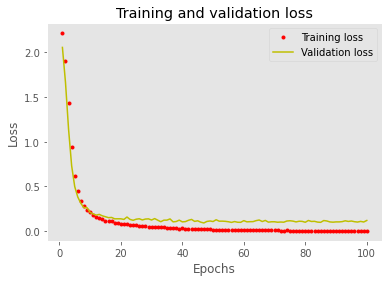

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('.\\figures\\history_traing.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Evaluation

### 8.1 Test Data

In [14]:
# Evaluate the original model
_, original_accuracy = model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 5ms/step - loss: 0.1198 - accuracy: 0.9610


In [15]:
# Measure the inference time of the original model
def measure_inference_time(model, x_test):
    times = []
    for _ in range(10):  
        start_time = time.time()
        model.predict(x_test[:1]) 
        times.append(time.time() - start_time)
    return np.mean(times)

In [16]:
original_inference_time = measure_inference_time(model, X_test)
print(f"Average inference time of the original model: {original_inference_time} seconds per sample")

1/1 [==============================] - 0s 84ms/step
Average inference time of the original model: 0.3914231538772583 seconds per sample


## 9. Apply Pruning

In [17]:
def apply_pruning(model, pruning_type='magnitude', **kwargs):
    """
    Applies pruning to the given model based on the specified pruning type.

    Parameters:
    - model: A Keras model to which pruning will be applied.
    - pruning_type: Type of pruning to apply. Supported types:
        'magnitude', 'random', 'l1', 'l2', 'iterative'
    - kwargs: Additional arguments depending on the pruning type.
        - For 'magnitude' and 'iterative':
            - 'initial_sparsity' (default: 0.0)
            - 'final_sparsity' (default: 0.5)
            - 'begin_step' (default: 0)
            - 'end_step' (default: 1000)
            - 'frequency' (default: 100)
        - For 'random':
            - 'sparsity' (default: 0.5)
        - For 'l1' and 'l2':
            - 'regularization_factor' (default: 1e-4)

    Returns:
    - A pruned Keras model ready for training.
    """

    # Default values for the kwargs
    initial_sparsity = kwargs.get('initial_sparsity', 0.0)
    final_sparsity = kwargs.get('final_sparsity', 0.5)
    begin_step = kwargs.get('begin_step', 0)
    end_step = kwargs.get('end_step', 1000)
    frequency = kwargs.get('frequency', 100)
    sparsity = kwargs.get('sparsity', 0.5)
    regularization_factor = kwargs.get('regularization_factor', 1e-4)
    
    if pruning_type == 'magnitude':
        # Magnitude-based pruning
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=initial_sparsity,
                final_sparsity=final_sparsity,
                begin_step=begin_step,
                end_step=end_step,
                frequency=frequency
            )
        }
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    
    elif pruning_type == 'random':
        # Random pruning
        def random_pruning_weights(weights, sparsity=0.5):
            mask = np.random.rand(*weights.shape) > sparsity
            return weights * mask

        # Apply random pruning to all dense layers
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                weights, biases = layer.get_weights()
                weights = random_pruning_weights(weights, sparsity=sparsity)
                layer.set_weights([weights, biases])
        pruned_model = model
    
    elif pruning_type in ['l1', 'l2']:
        # L1 or L2 regularization pruning
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                if pruning_type == 'l1':
                    layer.kernel_regularizer = tf.keras.regularizers.l1(regularization_factor)
                elif pruning_type == 'l2':
                    layer.kernel_regularizer = tf.keras.regularizers.l2(regularization_factor)
        pruned_model = model

    elif pruning_type == 'iterative':
        # Iterative pruning
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=initial_sparsity,
                final_sparsity=final_sparsity,
                begin_step=begin_step,
                end_step=end_step,
                frequency=frequency
            )
        }
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    else:
        raise ValueError(f"Unsupported pruning type: {pruning_type}")

    return pruned_model



In [18]:
# Apply magnitude pruning
pruned_model_magnitude = apply_pruning(model, pruning_type='magnitude', initial_sparsity=0.1, final_sparsity=0.8)

# Apply random pruning
pruned_model_random = apply_pruning(model, pruning_type='random', sparsity=0.5)

# Apply L1 regularization-based pruning
pruned_model_L1 = apply_pruning(model, pruning_type='l1', regularization_factor=1e-5)

# Apply iterative pruning
pruned_model_interative = apply_pruning(model, pruning_type='iterative', initial_sparsity=0.2, final_sparsity=0.7)

In [19]:
# Configurar o callback do pruning sem logs
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()  # Este callback é necessário
]

## 10. Compile the Pruning model 

In [20]:
pruned_model_magnitude.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

pruned_model_random.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

pruned_model_L1.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

pruned_model_interative.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

## 11. Training the Pruning model 

In [21]:
# Treinar o modelo podado
hist_pruned_model_magnitude = pruned_model_magnitude.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

hist_pruned_model_random = pruned_model_random.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

hist_pruned_model_L1 = pruned_model_L1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

hist_pruned_model_interative = pruned_model_interative.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
34/34 [==============================] - 9s 21ms/step - loss: 0.5261 - accuracy: 0.8599 - val_loss: 0.3143 - val_accuracy: 0.8942
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 0.2050 - accuracy: 0.9731 - val_loss: 0.2136 - val_accuracy: 0.9387
Epoch 3/100
34/34 [==============================] - 0s 11ms/step - loss: 0.1538 - accuracy: 0.9824 - val_loss: 0.2373 - val_accuracy: 0.9276
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 0.1345 - accuracy: 0.9861 - val_loss: 0.1830 - val_accuracy: 0.9471
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 0.1107 - accuracy: 0.9917 - val_loss: 0.1563 - val_accuracy: 0.9471
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.9685 - val_loss: 0.2114 - val_accuracy: 0.9387
Epoch 7/100
34/34 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.9694 - val_loss: 0.1534 - val_accuracy: 0.9415
Epoch 8/10

### 11.1 Strip model pruned

A "strip model" refers to a simplified or streamlined version of a model, often used in machine learning to reduce computational complexity and memory usage. When a strip model is pruned, it means that unnecessary parts of the model, such as less important neurons or connections, are removed. This process is aimed at improving the model's efficiency while maintaining its predictive performance. Pruning eliminates redundant or non-critical parameters to make the model smaller and faster, which is particularly useful for deploying models in resource-constrained environments like embedded systems or edge devices.

In [22]:
models_list = [pruned_model_magnitude, pruned_model_random, pruned_model_L1, pruned_model_interative, model]
models_list_name = ['pruned_model_magnitude', 'pruned_model_random', 'pruned_model_L1', 'pruned_model_interative', 'model_original']

In [23]:
def strip_and_save_pruned_model(pruned_model, model_name):
    # Remover pesos zerados usando strip pruning
    model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)
    
    # Salvar o modelo como .keras após strip pruning
    model_stripped.save(f'.\models\{model_name}.keras')
    
    return model_stripped

In [24]:
for i in range(len(models_list)):
    models_list[i] = strip_and_save_pruned_model(models_list[i], models_list_name[i])

## 12. Evaluation Pruned Model

In [25]:
pruned_model_magnitude_size = os.path.getsize('.\models\pruned_model_magnitude.keras') / 1024  # In KB
pruned_model_random_size = os.path.getsize('.\models\pruned_model_random.keras') / 1024  # In KB
pruned_model_L1_size = os.path.getsize('.\models\pruned_model_L1.keras') / 1024  # In KB
pruned_model_interative_size = os.path.getsize('.\models\pruned_model_interative.keras') / 1024  # In KB
original_size = os.path.getsize('.\models\original_model.keras') / 1024  # In KB

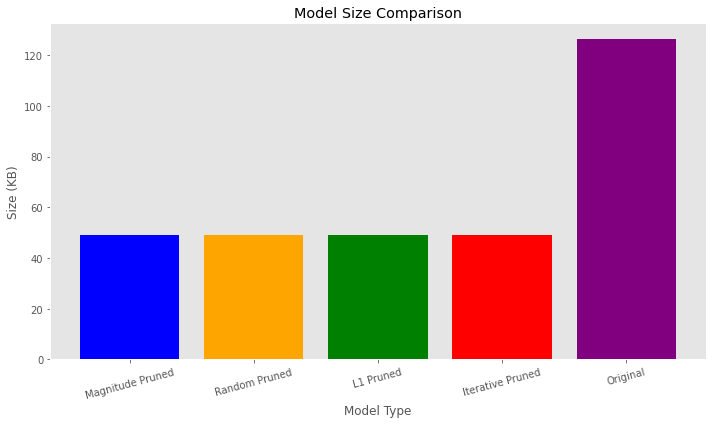

: 

In [37]:
model_sizes = {
    'Magnitude Pruned': pruned_model_magnitude_size,
    'Random Pruned': pruned_model_random_size,
    'L1 Pruned': pruned_model_L1_size,
    'Iterative Pruned': pruned_model_interative_size,
    'Original': original_size
}

# Create a bar chart to compare model sizes
plt.figure(figsize=(10, 6))
plt.bar(model_sizes.keys(), model_sizes.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Model Type')
plt.ylabel('Size (KB)')
plt.title('Model Size Comparison')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.grid()
plt.savefig('.\\figures\\model_size_pruned_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

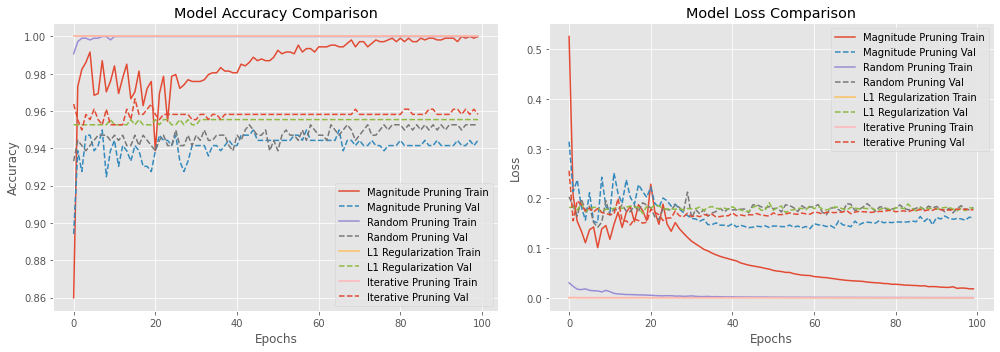

In [27]:
history_objects = {
    "Magnitude Pruning": hist_pruned_model_magnitude,
    "Random Pruning": hist_pruned_model_random,
    "L1 Regularization": hist_pruned_model_L1,
    "Iterative Pruning": hist_pruned_model_interative
}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
for label, hist in history_objects.items():
    ax1.plot(hist.history['accuracy'], label=f'{label} Train')
    ax1.plot(hist.history['val_accuracy'], linestyle='--', label=f'{label} Val')

ax1.set_title('Model Accuracy Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
for label, hist in history_objects.items():
    ax2.plot(hist.history['loss'], label=f'{label} Train')
    ax2.plot(hist.history['val_loss'], linestyle='--', label=f'{label} Val')

ax2.set_title('Model Loss Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.savefig('.\\figures\\history_pruning_traing.png', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# Evaluate magnitude-pruned model
_, pruned_accuracy_magnitude = pruned_model_magnitude.evaluate(X_test, y_test)
pruned_inference_time_magnitude = measure_inference_time(pruned_model_magnitude, X_test)

# Evaluate random-pruned model
_, pruned_accuracy_random = pruned_model_random.evaluate(X_test, y_test)
pruned_inference_time_random = measure_inference_time(pruned_model_random, X_test)

# Evaluate L1 regularization-pruned model
_, pruned_accuracy_L1 = pruned_model_L1.evaluate(X_test, y_test)
pruned_inference_time_L1 = measure_inference_time(pruned_model_L1, X_test)

# Evaluate iterative-pruned model
_, pruned_accuracy_iterative = pruned_model_interative.evaluate(X_test, y_test)
pruned_inference_time_iterative = measure_inference_time(pruned_model_interative, X_test)

1/1 [==============================] - 0s 31ms/step


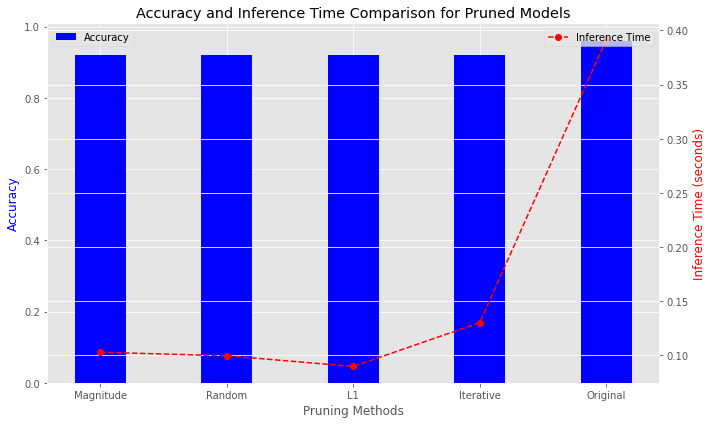

In [29]:
# Define the accuracy and inference time for each pruning method
pruning_methods = ['Magnitude', 'Random', 'L1', 'Iterative', 'Original']
accuracy_values = [pruned_accuracy_magnitude, pruned_accuracy_random, pruned_accuracy_L1, pruned_accuracy_iterative, original_accuracy]
inference_times = [pruned_inference_time_magnitude, pruned_inference_time_random, pruned_inference_time_L1, pruned_inference_time_iterative, original_inference_time]

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a bar chart for accuracy
ax1.bar(np.arange(len(pruning_methods)), accuracy_values, width=0.4, label='Accuracy', color='b', align='center')

# Set axis labels and title
ax1.set_xlabel('Pruning Methods')
ax1.set_ylabel('Accuracy', color='b')
ax1.set_title('Accuracy and Inference Time Comparison for Pruned Models')

# Set x-ticks to pruning methods
ax1.set_xticks(np.arange(len(pruning_methods)))
ax1.set_xticklabels(pruning_methods)

# Create another y-axis for inference time on the same plot
ax2 = ax1.twinx()
ax2.plot(np.arange(len(pruning_methods)), inference_times, label='Inference Time', color='r', marker='o', linestyle='--')
ax2.set_ylabel('Inference Time (seconds)', color='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.savefig('.\\figures\\time_acc_pruning_comparative.png', dpi=300, bbox_inches='tight')
plt.show()


## 13. Obtaining the model to be implemented in the microcontroller

### 13.1 Convert some hex value into an array for C programming

In [30]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifdef __has_attribute\n'
  c_str += '#define HAVE_ATTRIBUTE(x) __has_attribute(x)\n'
  c_str += '#else\n'
  c_str += '#define HAVE_ATTRIBUTE(x) 0\n'
  c_str += '#endif\n'
  c_str += '#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))\n'
  c_str += '#else\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE\n'
  c_str += '#endif\n\n'

  # Declare C variable
  c_str += 'const unsigned char ' + var_name + '[]  DATA_ALIGN_ATTRIBUTE = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += 'const int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  return c_str

### 13.2 Convert o pruned model to Float32

In [31]:
def representative_dataset():
    # Yield data in the shape expected by the model
    for i in range(len(X_train)):
        input_data = np.array([X_train[i]], dtype=np.float32)
        yield [input_data]

def converter_quantization_model(model, model_name):

    # Convert the model to float32
    converter_float32 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_float32.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_float32.target_spec.supported_types = [tf.float32]
    converter_float32.representative_dataset = representative_dataset

    # Convert and save float32 model
    tflite_model_float32 = converter_float32.convert()
    with open(f".\models\{model_name}" + '_quant_float32' + '.h', 'w') as file:
        file.write(hex_to_c_array(tflite_model_float32, f".\models\{model_name}" + '_quant_float32'))
    with open(f".\models\{model_name}" + '_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)

    # Get sizes
    size_model_tflite_float32 = os.path.getsize(f".\models\{model_name}" + '_quant_float32.tflite')
    size_model_h_float32 = os.path.getsize(f".\models\{model_name}" + '_quant_float32.h')
    print(f".\models\{model_name}" + f'_quant_float32.tflite: {size_model_tflite_float32} Bytes')
    print(f".\models\{model_name}" + f'_quant_float32.h: {size_model_h_float32} Bytes')

    
    return size_model_tflite_float32, size_model_h_float32


In [32]:
# Lists to hold sizes
sizes_float32 = []


# Loop through each model to get the sizes
for i in range(len(models_list)):
    size_model_tflite_float32, size_model_h_float32 = converter_quantization_model(models_list[i], models_list_name[i])
    sizes_float32.append(size_model_tflite_float32)  # Append float32 size

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmppuzz7u82\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmppuzz7u82\assets


.\models\pruned_model_magnitude_quant_float32.tflite: 36284 Bytes
.\models\pruned_model_magnitude_quant_float32.h: 227239 Bytes
INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpseu_k629\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpseu_k629\assets


.\models\pruned_model_random_quant_float32.tflite: 36284 Bytes
.\models\pruned_model_random_quant_float32.h: 227233 Bytes
INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmp3nw1th8i\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmp3nw1th8i\assets


.\models\pruned_model_L1_quant_float32.tflite: 36284 Bytes
.\models\pruned_model_L1_quant_float32.h: 227225 Bytes
INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpde54ybw0\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpde54ybw0\assets


.\models\pruned_model_interative_quant_float32.tflite: 36284 Bytes
.\models\pruned_model_interative_quant_float32.h: 227241 Bytes
INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpvq8yfx42\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpvq8yfx42\assets


.\models\model_original_quant_float32.tflite: 36284 Bytes
.\models\model_original_quant_float32.h: 227223 Bytes


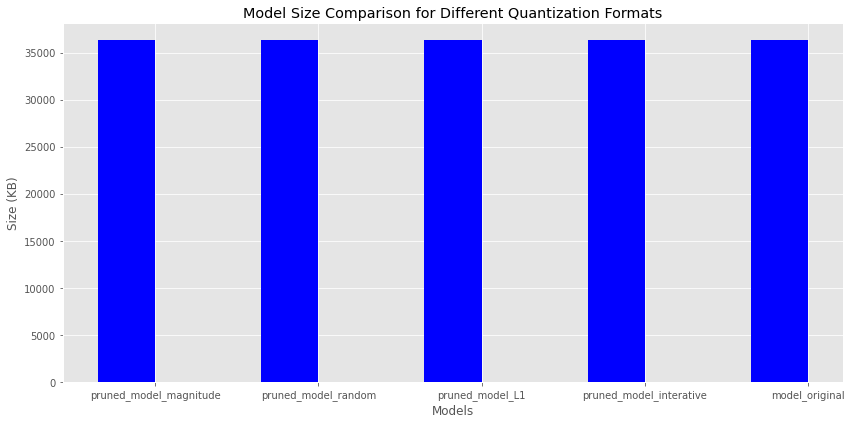

In [33]:
# Define x-axis labels for the models
x_labels = models_list_name

# Set the width of the bars
bar_width = 0.35
x = range(len(x_labels))

# Create a bar chart for the sizes
plt.figure(figsize=(12, 6))
plt.bar(x, sizes_float32, width=bar_width,  color='blue', align='center')


# Add labels and title
plt.xlabel('Models')
plt.ylabel('Size (KB)')
plt.title('Model Size Comparison for Different Quantization Formats')
plt.xticks([p + bar_width / 2 for p in x], x_labels)


# Show the plot
plt.tight_layout()
plt.savefig('.\\figures\\size_PTQ_comparative.png', dpi=300, bbox_inches='tight')
plt.show()


## 14. Quantized Pruned Model Evaluation

In [34]:
def evaluate_quantization(model_path, X_test, y_test, quantization_type):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Avaliar o modelo quantizado
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []
    processing_times = []

    X_test = np.array(X_test, dtype=np.float32)
    
    for X in X_test:
        interpreter.set_tensor(input_index, [X])       
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        output = interpreter.get_tensor(output_index).argmax(axis=1)
        predictions.append(output[0])

    acc = accuracy_score(y_test, predictions)


    return acc, processing_time

In [35]:
acc_float32 = []
time_float32 = []

# Loop through each model to get the sizes
for i in range(len(models_list_name )):
    acc, processing_time = evaluate_quantization(f".\models\{models_list_name[i]}" + '_quant_float32.tflite', X_test, y_test, 'float32')
    acc_float32.append(acc)  # Append float32 size
    time_float32.append(processing_time)  # Append int8 size

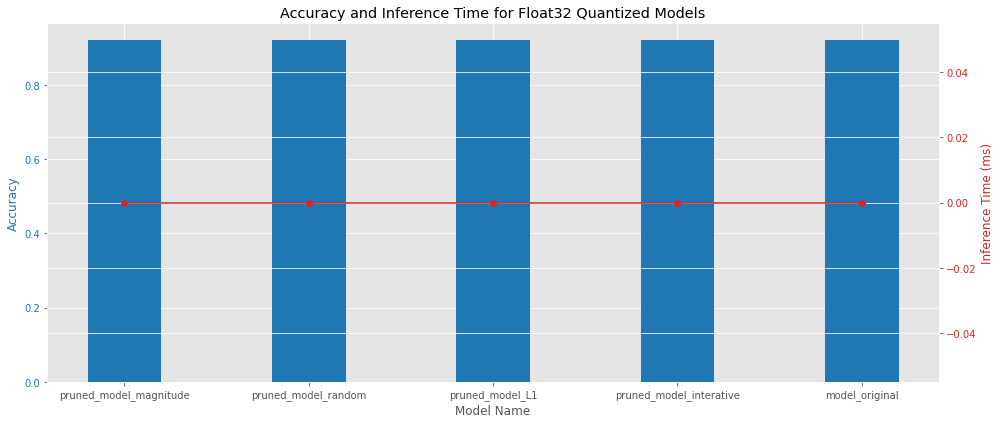

In [36]:
# Plot the accuracy vs. inference time for float32 models
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot accuracy
ax1.set_xlabel('Model Name')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.bar(models_list_name, acc_float32, color='tab:blue', width=0.4, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for inference time
ax2 = ax1.twinx()
ax2.set_ylabel('Inference Time (ms)', color='tab:red')
ax2.plot(models_list_name, time_float32, color='tab:red', marker='o', label='Inference Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set title
plt.title('Accuracy and Inference Time for Float32 Quantized Models')

# Show plot
plt.tight_layout()
plt.savefig('.\\figures\\acc_quantized_model.png', dpi=300, bbox_inches='tight')
plt.show()